In [1]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter

In [2]:
def read_pdf_and_get_chunks(pdf_path):
    # Load the PDF file
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Combine all the text from the PDF
    raw_text = " ".join([doc.page_content for doc in documents])

    # Split the text into chunks
    text_splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    chunks = text_splitter.split_text(raw_text)

    return chunks

In [3]:
chunks = read_pdf_and_get_chunks("C:/Users/jainh/Downloads/atomichabits.pdf")

In [4]:
import time
import requests
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

def fetch_embedding(url, chunk, log_times):
    payload = {
        "model": "nomic-embed-text",
        "prompt": chunk
    }
    start_time = time.time()
    log_times.append(("start", start_time))  # Log start time
    try:
        response = requests.post(url, data=json.dumps(payload), headers={"Content-Type": "application/json"})
        end_time = time.time()
        log_times.append(("end", end_time))  # Log end time
        if response.status_code == 200:
            return {"embedding": response.json().get("embedding", []), "time": end_time - start_time}
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return {"embedding": None, "time": end_time - start_time}
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        end_time = time.time()
        log_times.append(("end", end_time))  # Log end time
        return {"embedding": None, "time": None}

def generate_embeddings_for_chunks_concurrently(chunks, max_workers=5):
    url = "http://localhost:11434/api/embeddings"
    
    embeddings = []
    timings = []
    log_times = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fetch_embedding, url, chunk, log_times): chunk for chunk in chunks}
        
        for future in as_completed(futures):
            result = future.result()
            embeddings.append(result["embedding"])
            timings.append(result["time"])
    
    return {"embeddings": embeddings, "timings": timings, "log_times": log_times}

def plot_concurrency(log_times):
    events = sorted(log_times, key=lambda x: x[1])
    times = []
    concurrency = []
    current_concurrency = 0
    
    for event, timestamp in events:
        if event == "start":
            current_concurrency += 1
        elif event == "end":
            current_concurrency -= 1
        times.append(timestamp)
        concurrency.append(current_concurrency)
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, concurrency, drawstyle="steps-post", label="Concurrency")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of Concurrent Requests")
    plt.title("Concurrency Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
import time
import matplotlib.pyplot as plt
import numpy as np

def test_optimal_concurrency(chunks, worker_counts):
    """
    Test the model for optimal concurrency by varying max_workers and logging the total time 
    and average time for each request based on the result timings.
    
    Args:
        chunks (list): List of text chunks for which embeddings are to be generated.
        worker_counts (list): List of max_workers values to test.
    
    Returns:
        dict: Results containing worker_counts, total_times, and avg_times.
    """
    total_times = []
    avg_times = []
    
    for workers in worker_counts:
        print(f"Testing with max_workers={workers}...")
        
        # Measure the total start time
        start_time = time.time()
        
        # Generate embeddings concurrently
        result = generate_embeddings_for_chunks_concurrently(chunks, max_workers=workers)
        
        # Measure the total time taken
        total_time = time.time() - start_time
        
        # Calculate the average time from timings in the result
        valid_timings = [t for t in result["timings"] if t is not None]  # Exclude failed requests
        avg_time = np.mean(valid_timings) if valid_timings else float('inf')
        
        # Append results
        total_times.append(total_time)
        avg_times.append(avg_time)
        
        print(f"Total time: {total_time:.2f} seconds, Average timing from API: {avg_time:.4f} seconds")
    
    return {"worker_counts": worker_counts, "total_times": total_times, "avg_times": avg_times}

def plot_concurrency_tests(results):
    """
    Plot the total and average times for different max_workers values.
    """
    worker_counts = results["worker_counts"]
    total_times = results["total_times"]
    avg_times = results["avg_times"]
    
    plt.figure(figsize=(12, 6))
    
    # Plot total times
    plt.plot(worker_counts, total_times, label="Total Time (seconds)", marker="o")
    
    # Plot average times
    plt.plot(worker_counts, avg_times, label="Average Time per Request (seconds)", marker="o")
    
    plt.xlabel("Number of Workers (max_workers)")
    plt.ylabel("Time (seconds)")
    plt.title("Performance Analysis of Concurrent Requests")
    plt.legend()
    plt.grid(True)
    plt.show()

Testing with max_workers=10...
Total time: 47.17 seconds, Average timing from API: 2.3046 seconds
Testing with max_workers=15...
Total time: 43.25 seconds, Average timing from API: 3.1329 seconds
Testing with max_workers=20...
Total time: 43.05 seconds, Average timing from API: 4.1069 seconds
Testing with max_workers=25...
Total time: 43.20 seconds, Average timing from API: 5.0834 seconds
Testing with max_workers=30...
Total time: 43.29 seconds, Average timing from API: 6.0414 seconds
Testing with max_workers=35...
Total time: 43.28 seconds, Average timing from API: 6.9555 seconds
Testing with max_workers=40...
Total time: 43.12 seconds, Average timing from API: 7.8172 seconds
Testing with max_workers=45...
Total time: 43.22 seconds, Average timing from API: 8.6894 seconds
Testing with max_workers=50...
Total time: 43.10 seconds, Average timing from API: 9.5025 seconds


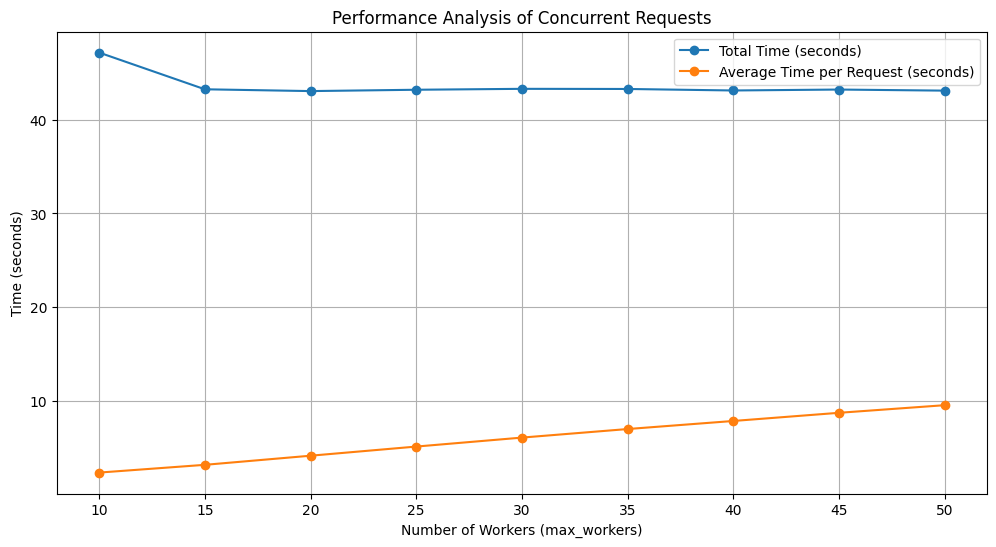

In [7]:
worker_counts = [10,15, 20,25, 30,35, 40,45, 50]
results = test_optimal_concurrency(chunks[:200], worker_counts)
plot_concurrency_tests(results)